<a href="https://colab.research.google.com/github/lewisevans38/Suez-Time-Series-Anomaly-Detection-/blob/main/LSTMAEonNAB_artificialjumpsdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt
import math
from copy import deepcopy
from sklearn.model_selection import train_test_split

# anomalous
URL1= "https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsdown.csv"
DATA1 = pd.read_csv(URL1)

In [ ]:
df  = DATA1

train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
scaler = scaler.fit(train[['value']])
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])
df['value'] = scaler.transform(df[['value']])


def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

(3830, 2) (202, 2)


<ipython-input-2-70c087ddc8f0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-2-70c087ddc8f0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [ ]:
TIME_STEPS = 6
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)
print(X_train.shape)

##Turn into pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_train.shape)

(3824, 6, 1)
torch.Size([3824, 6, 1])


In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))



In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(TIME_STEPS, 1, 128)
model = model

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum')
  history = dict(train=[], val=[])

  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  X_train,
  X_test,
  n_epochs=30
)

Epoch 1: train loss 2.3802724240979014 val loss 5.664689456321756
Epoch 2: train loss 1.7507268450842493 val loss 5.703500967548818
Epoch 3: train loss 2.4840283556588023 val loss 5.744218704651813
Epoch 4: train loss 2.298168533524522 val loss 5.683758495109422
Epoch 5: train loss 2.499193808211941 val loss 5.6470198856324565
Epoch 6: train loss 2.393266611401319 val loss 5.704161882704618
Epoch 7: train loss 1.0424908221422629 val loss 5.647933657680239
Epoch 8: train loss 1.664673021164524 val loss 5.619277711425509
Epoch 9: train loss 0.7951882437385899 val loss 0.7502879348336434
Epoch 10: train loss 0.6661208857037907 val loss 0.7684901174233885
Epoch 11: train loss 0.6025784311652433 val loss 0.7822618326362298
Epoch 12: train loss 0.5802628299042146 val loss 0.7267422849426464
Epoch 13: train loss 0.5666655263937542 val loss 0.7212893663316357
Epoch 14: train loss 0.577009240009483 val loss 0.7155870594540421
Epoch 15: train loss 0.585530630020604 val loss 0.7394983345756725
Ep

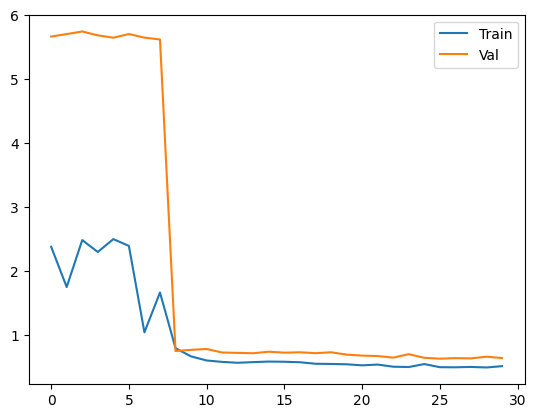

In [ ]:
plt.plot(history['train'], label = 'Train')
plt.plot(history['val'], label ='Val')
plt.legend()
plt.show()

In [ ]:
predictions = []
model = model.eval()
with torch.no_grad():
  for seq_true in X_train:

    seq_true = seq_true
    seq_pred = model(seq_true)
    predictions.append(seq_pred[:][-1].item())
  for seq_true in X_test:

    seq_true = seq_true
    seq_pred = model(seq_true)
    predictions.append(seq_pred[:][-1].item())



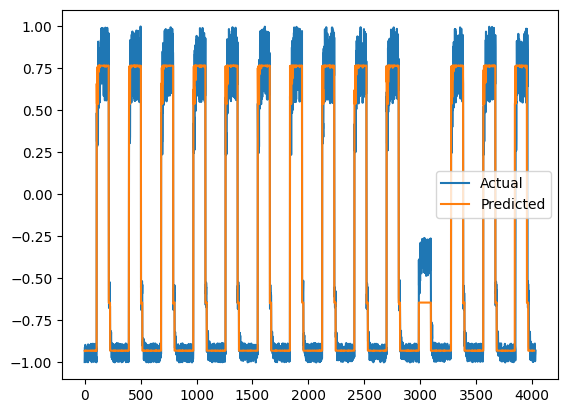

In [ ]:

plt.plot(df['value'], label = 'Actual')
plt.plot(predictions, label ='Predicted')
plt.legend()
plt.show()

In [ ]:
df

,timestamp,value
0,2014-04-01 00:00:00,-0.997473
1,2014-04-01 00:05:00,-0.932631
2,2014-04-01 00:10:00,-0.911326
3,2014-04-01 00:15:00,-0.910008
4,2014-04-01 00:20:00,-0.996140
...,...,...
4027,2014-04-14 23:35:00,-0.992364
4028,2014-04-14 23:40:00,-0.968990
4029,2014-04-14 23:45:00,-0.954493
4030,2014-04-14 23:50:00,-0.949547


In [ ]:
DATA1

,timestamp,value
0,2014-04-01 00:00:00,-0.997473
1,2014-04-01 00:05:00,-0.932631
2,2014-04-01 00:10:00,-0.911326
3,2014-04-01 00:15:00,-0.910008
4,2014-04-01 00:20:00,-0.996140
...,...,...
4027,2014-04-14 23:35:00,-0.992364
4028,2014-04-14 23:40:00,-0.968990
4029,2014-04-14 23:45:00,-0.954493
4030,2014-04-14 23:50:00,-0.949547


In [ ]:

indextracker = []
difference = []
DATA1 = pd.read_csv(URL1).set_index('timestamp')
for x in range(0,len(predictions)):
  diff = abs(df['value'][x] - predictions[x])
  difference.append(diff)
standard_deviation = np.std(difference)
Mean = np.mean(difference)
for x in range (0,len(difference)):
 if difference[x] >3*standard_deviation+ Mean:
    indextracker.append(x)
print("The anomalous points are at" , indextracker)
print("The total amount of anomalies is",len(indextracker))

NameError: name 'pd' is not defined

In [ ]:
DATA2 = pd.read_csv(URL1)#.set_index('timestamp')
for x in range(0,len(indextracker)):
  print(DATA2.iloc[indextracker[x]+TIME_STEPS]['timestamp'])

2014-04-14 09:00:00
2014-04-14 09:05:00
2014-04-14 09:10:00
2014-04-14 09:15:00
2014-04-14 09:20:00
2014-04-14 09:25:00
2014-04-14 09:45:00
2014-04-14 10:00:00
2014-04-14 10:05:00
2014-04-14 18:00:00
2014-04-14 18:05:00
2014-04-14 18:10:00
2014-04-14 18:15:00
2014-04-14 18:20:00
2014-04-14 18:25:00


In [ ]:
2014-04-11 09:00:00"